<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>RNNs for Timeseries Analysis</h1>
        <h2>Recurrent Neural Networks Lab</h2>

</div>

In [2]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import watermark

%load_ext watermark
%matplotlib inline

ModuleNotFoundError: ignored

In [3]:
pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00


Let's start by print out the versions of the libraries we're using for future reference

# Load dataset

GDP data from the Federal Reserve Bank [website](https://fred.stlouisfed.org/series/GDP)

In [4]:
dataset = pd.read_csv('/content/GDP.csv', header=0, parse_dates=[0], index_col=0)

It's always important to see what you are doing. You can save a lot of time like this ;)

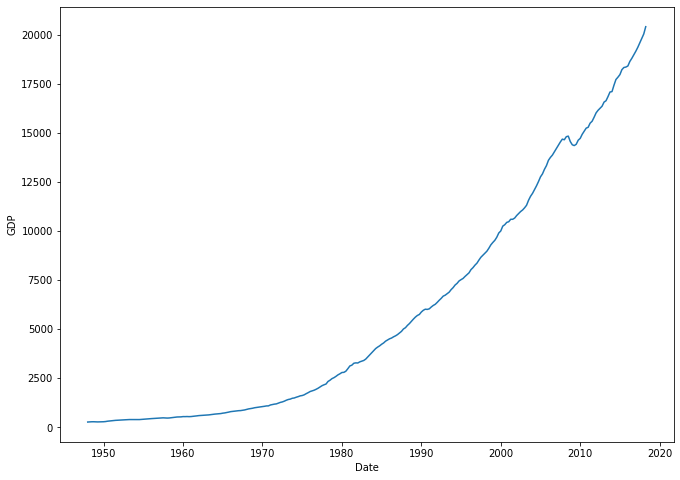

In [5]:
plt.plot(dataset['GDP'])
plt.xlabel('Date')
plt.ylabel('GDP');
plt.gcf().set_size_inches(11,8)

You might remember the little "dip" around 2009.

## Calculate the QoQ growth
The outputs of a SimpleRNN are generated by an tanh function. Here we limit the values of our timeseries to be within [-1, 1] to avoid numerical issues. This also has the added advantage of making the timeseries (relatively) stationary

In [7]:
dataset['diff'] = 0
series = dataset['GDP'].pct_change().dropna().values.reshape(-1,1)
dataset.loc[1:, 'diff']=series

<ipython-input-7-1806efba4565>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[1:, 'diff']=series


## Training and Testing datasets 
The y values are just the next x value

In [8]:
values = series.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)
X = values[:-1]
y = values[1:]

We'll be using the first 2/3 of the timeseries to train the model and the last 1/3 to evaluate it.

In [9]:
n_points = len(series)
train_points = int(2/3*n_points)+1
X_train, X_test = X[:train_points], X[train_points:]
y_train, y_test = y[:train_points], y[train_points:]
print("We have", len(X_train), "training points and", X_test.shape[0], "testing points")

We have 188 training points and 92 testing points


The SimpleRNN model expects a 3D ([samples, time steps, features]) dataset so we reshape them accordingly 

In [11]:
tf.compat.v1.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

(188, 1, 1)
(92, 1, 1)


We're only using one timestep

## Define the model architecture. 
We'll be using a SimpleRNN model. The Dense layer at the end has a linear activation function to aggregate the outputs of all the hidden units.

In [12]:
model = Sequential()
model.add(SimpleRNN(units=10, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [13]:
nb_epoch = 100

model.fit(X_train, y_train, epochs=nb_epoch, batch_size=16)

Epoch 1/100
12/12 [==============================] - 2s 9ms/step - loss: 0.2378
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 0.2143
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 0.1951
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 0.1798
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.1671
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.1577
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.1482
Epoch 8/100
12/12 [==============================] - 0s 7ms/step - loss: 0.1396
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.1322
Epoch 10/100
12/12 [==============================] - 0s 7ms/step - loss: 0.1254
Epoch 11/100
12/12 [==============================] - 0s 6ms/step - loss: 0.1195
Epoch 12/100
12/12 [==============================] - 0s 10ms/step - loss: 0.1139
Epoch 13/100
12/12 [================

## Make predictions

In [14]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


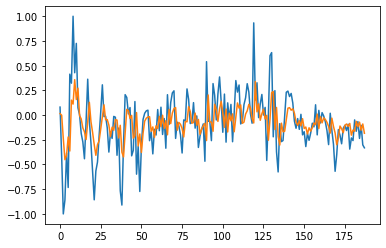

In [15]:
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train_pred)), y_train_pred)

Compute the actual values

In [20]:
dataset['RNN_train_predict'] = 1
dataset['RNN_test_predict'] = 1
dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['RNN_train_predict'] = dataset.iloc[0]['GDP']*dataset['RNN_train_predict'].cumprod()
dataset['RNN_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod()

<ipython-input-20-a40fad6d2eb9>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[1:train_points+1, 'RNN_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
<ipython-input-20-a40fad6d2eb9>:4: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[train_points+2:, 'RNN_test_predict'] = 1+scaler.inverse_transform(y_test_pred)


In [24]:
print(dataset.iloc[train_points+1]['GDP']*dataset['RNN_test_predict'].cumprod())

DATE
1948-01-01    5.747152e+07
1948-04-01    4.356914e+11
1948-07-01    3.302975e+15
1948-10-01    2.503984e+19
1949-01-01    1.898270e+23
                  ...     
2017-04-01             inf
2017-07-01             inf
2017-10-01             inf
2018-01-01             inf
2018-04-01             inf
Name: RNN_test_predict, Length: 282, dtype: float64


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


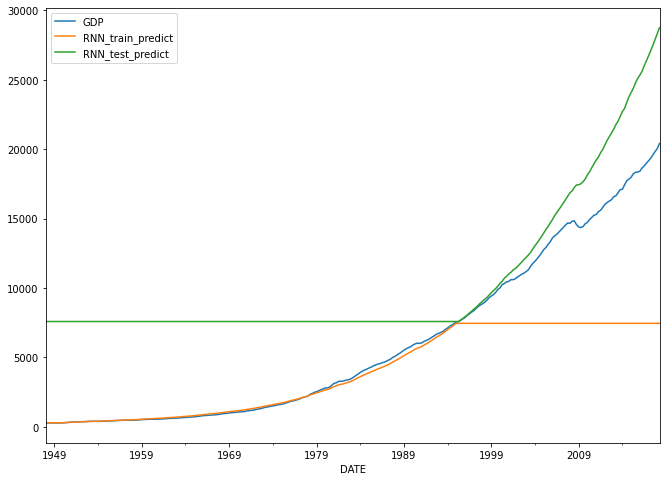

In [21]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# LSTM
Let's now try using a slightly more sophisticated architecture

In [16]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [26]:
nb_epoch = 500

model.fit(X_train, y_train, epochs=nb_epoch)

Epoch 1/500
6/6 [==============================] - 0s 4ms/step - loss: 0.0720
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0721
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0721
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 7/500
6/6 [==============================] - 0s 4ms/step - loss: 0.0720
Epoch 8/500
6/6 [==============================] - 0s 4ms/step - loss: 0.0720
Epoch 9/500
6/6 [==============================] - 0s 4ms/step - loss: 0.0720
Epoch 10/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 11/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 12/500
6/6 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 13/500
6/6 [==============================] - 0s 3ms/st

Calculate the predicted values

In [18]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

dataset['LSTM_train_predict'] = 1
dataset['LSTM_test_predict'] = 1
dataset.loc[1:train_points+1, 'LSTM_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
dataset.loc[train_points+2:, 'LSTM_test_predict'] = 1+scaler.inverse_transform(y_test_pred)

dataset['LSTM_train_predict'] = dataset.iloc[0]['GDP']*dataset['LSTM_train_predict'].cumprod()
dataset['LSTM_test_predict'] = dataset.iloc[train_points+1]['GDP']*dataset['LSTM_test_predict'].cumprod()

3/3 [==============================] - 0s 6ms/step


<ipython-input-18-d07942b6599a>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[1:train_points+1, 'LSTM_train_predict'] = 1+scaler.inverse_transform(y_train_pred)
<ipython-input-18-d07942b6599a>:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  dataset.loc[train_points+2:, 'LSTM_test_predict'] = 1+scaler.inverse_transform(y_test_pred)


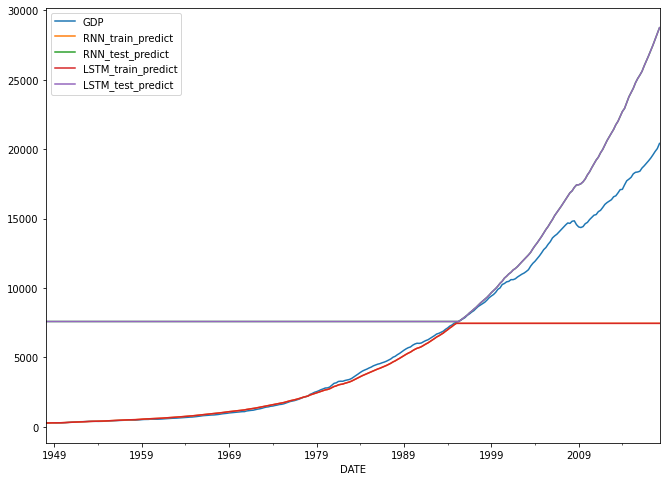

In [27]:
dataset[['GDP', 'RNN_train_predict', 'RNN_test_predict', 'LSTM_train_predict', 'LSTM_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)